In [106]:
import pandas as pd
import refinitiv.data as rd
import random
import copy
import numpy as np
import matplotlib.pyplot as plt

from os.path import exists
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.model_selection import train_test_split
from math import sqrt

In [100]:
plt.rcParams["figure.figsize"] = (16, 8)

In [55]:
if not exists('../data/alphabet.csv'):
    ek.set_app_key('DEFAULT_CODE_BOOK_APP_KEY')

    df, err = ek.get_data(
        instruments = ['GOOG.O'],
        fields = ['TR.PriceCloseDate(Frq=D,SDate=2017-01-01,EDate=2022-05-24)',
            'TR.CLOSEPRICE(Frq=D,SDate=2017-01-01,EDate=2022-05-24)',
            'TR.ACCUMULATEDVOLUME(Frq=D,SDate=2017-01-01,EDate=2022-05-24)',
            'TR.BLOCKTRADEVOLUME(Frq=D,SDate=2017-01-01,EDate=2022-05-24)',
            'TR.TSVWAP(Frq=D,SDate=2017-01-01,EDate=2022-05-24)',
            'TR.HIGHPRICE(Frq=D,SDate=2017-01-01,EDate=2022-05-24)',
            'TR.LOWPRICE(Frq=D,SDate=2017-01-01,EDate=2022-05-24)',
            'TR.OPENPRICE(Frq=D,SDate=2017-01-01,EDate=2022-05-24)',
            'TR.NUMBEROFBLOCKTRADES(Frq=D,SDate=2017-01-01,EDate=2022-05-24)'
        ]
    )
    df.to_csv('../data/alphabet.csv', index=True)
else:
    df = pd.read_csv('../data/alphabet.csv')

In [56]:
df

,Instrument,Date,Close Price,Accumulated Volume,Block Trade Volume,VWAP,High Price,Low Price,Open Price,Number of Block Trades
0,GOOG.O,2017-01-03T00:00:00Z,771.82,1769950,284924,774.0456,782.7800,770.4100,782.75,5
1,GOOG.O,2017-01-04T00:00:00Z,786.90,1072958,84565,786.9607,791.3400,783.1600,788.36,2
2,GOOG.O,2017-01-05T00:00:00Z,794.02,1335167,196233,791.2923,794.4800,785.0200,786.08,4
3,GOOG.O,2017-01-06T00:00:00Z,806.15,1640170,178053,803.6478,807.9000,792.2041,795.26,4
4,GOOG.O,2017-01-09T00:00:00Z,806.65,1274645,143526,807.0389,809.9664,802.8300,806.40,4
...,...,...,...,...,...,...,...,...,...,...
1353,GOOG.O,2022-05-18T00:00:00Z,2248.02,1399138,220898,2268.3937,2313.9134,2242.8400,2304.75,4
1354,GOOG.O,2022-05-19T00:00:00Z,2214.91,1459587,124507,2234.8438,2271.7500,2209.3600,2236.82,3
1355,GOOG.O,2022-05-20T00:00:00Z,2186.26,1879301,222277,2175.1869,2251.0000,2127.4600,2241.71,4
1356,GOOG.O,2022-05-23T00:00:00Z,2233.33,1577911,161267,2220.4407,2240.1100,2183.0850,2202.08,4


### Imputation

Imputation is a process that can be used to deal with missing values. While deleting missing values is a possible approach to tackle the problem, it can lead to significant degrading of the dataset as it decreases the volume of available data. Imputation tries to fill in the missing values, categorical or numeric, and there are numerous techniques that can be used during the process. Let's randomly remove 5% of the records from the Number of Block Trades so we can explore some of the methodologies:

In [65]:
block_trades = copy.deepcopy(df['Number of Block Trades'])
ix_remove = [random.randrange(1, len(block_trades), 1) for i in range(int(0.1*len(block_trades)))]
block_trades.iloc[ix_remove] = np.nan

In [66]:
block_trades_nans = copy.deepcopy(block_trades)
block_trades

0       5.0
1       2.0
2       NaN
3       4.0
4       4.0
       ... 
1353    4.0
1354    3.0
1355    4.0
1356    4.0
1357    4.0
Name: Number of Block Trades, Length: 1358, dtype: float64

The easiest way to impute missing value is to use a statistic generated through the series itself and replace all NaNs with it. Here's an attempt to use the mean as a replacement value. The median and mode is always another option that can be used.

In [67]:
block_trades_pandas = np.ndarray.flatten(block_trades.fillna(block_trades.mean()).to_numpy().reshape(-1, 1))

In [68]:
block_trades_pandas

array([5.        , 2.        , 4.40243902, ..., 4.        , 4.        ,
       4.        ])

Let's now turn into other possible methodologies and use the impute module within scikit-learn. The SimpleImputer is essentially the same with the pandas methodology and we can again ask for different imputation strategies. 

In [69]:
block_trades_array_simp = block_trades_nans.to_numpy().reshape(-1, 1)

s_imp = SimpleImputer(missing_values=np.nan, strategy='median')
s_imp.fit(block_trades_array_simp)
block_trades_array_simp = np.ndarray.flatten(s_imp.transform(block_trades_array_simp))

block_trades_array_simp

array([5., 2., 4., ..., 4., 4., 4.])

While the SimpleImputer can only treat the feature as a disconnected series, IterativeImputer can leverage on other feature data to impute the missing values. Essentialy IterativeImputer can generate a function of the treated feature against the other available features. The IterativeImputer is only available as an experimental feature in sklearn. Let's impute the number of block trades taking into account the Block Trade Volume.

In [75]:
block_trades_array_iimp = block_trades_nans.to_numpy().reshape(-1, 1)
block_trade_volume_array = df['Block Trade Volume'].to_numpy().reshape(-1, 1)

i_imp = IterativeImputer()
i_imp.fit(block_trade_volume_array)

block_trades_array_iimp = np.ndarray.flatten(i_imp.transform(block_trades_array_iimp))
block_trades_array_iimp

array([5.00000000e+00, 2.00000000e+00, 2.34793858e+05, ...,
       4.00000000e+00, 4.00000000e+00, 4.00000000e+00])

Another interesting imputer available in sklearn.impute is the K Nearest Neighbor imputer. The methodology will first try to create feature clusters then use the mean of the cluster to impute the missing values. 

In [71]:
block_trades_array_knnimp = block_trades_nans.to_numpy().reshape(-1, 1)

knn_imp = KNNImputer(n_neighbors=50)
knn_imp.fit(block_trades_array_knnimp)
block_trades_array_knnimp = np.ndarray.flatten(knn_imp.transform(block_trades_array_knnimp))

block_trades_array_knnimp

array([5.        , 2.        , 4.40243902, ..., 4.        , 4.        ,
       4.        ])

Let's now use the Root Mean Square Error (RMSE) and the more intuitive Mean Absolute Percentage Error (MAPE) to evaluate the different imputation methods we showcased and see which one performed the best in the specific use case. For the purposes of MAPE we write a small function.

In [73]:
def mape(actual, pred):
    return np.mean(np.abs((actual-pred)/actual)* 100)

block_trades_actual = df['Number of Block Trades'].to_numpy()
rmse_pandas = sqrt(mean_squared_error(block_trades_actual, block_trades_pandas))
mape_pandas = mape(block_trades_actual, block_trades_pandas)

print(f'Pandas Imputation RMSE:{rmse_pandas}, MAPE:{mape_pandas}%')

rmse_simp = sqrt(mean_squared_error(block_trades_actual, block_trades_array_simp))
mape_simp = mape(block_trades_actual, block_trades_array_simp)

print(f'Median Imputation RMSE:{rmse_simp}, MAPE:{mape_simp}%')

rmse_iimp = sqrt(mean_squared_error(block_trades_actual, block_trades_array_iimp))
mape_iimp = mape(block_trades_actual, block_trades_array_iimp)

print(f'Iterative Imputation RMSE:{rmse_iimp}, MAPE:{mape_iimp}%')

rmse_knnimp = sqrt(mean_squared_error(block_trades_actual, block_trades_array_knnimp))
mape_knnimp = mape(block_trades_actual, block_trades_array_knnimp)

print(f'KNN Imputation RMSE:{rmse_knnimp}, MAPE:{mape_knnimp}%')

Pandas Imputation RMSE:0.6763511663087829, MAPE:3.965007373748259%
Median Imputation RMSE:0.6929053473051033, MAPE:3.4679266895761742%
Iterative Imputation RMSE:72083.10868837175, MAPE:603280.3480915561%
KNN Imputation RMSE:0.6763511663087829, MAPE:3.965007373748259%


We can see from the results that the iterative imputator failed to generate a good function estimate of block trades using block trade volume and that the best imputation approach on this case is the Median Imputation from the SimpleImpute module. There exist many more Imputation approaches and some can be more sophisticated like e.g. using Random Forests for Imputation.

### Scaling 
AI and machine learning algorithms can be very sensitive to the scale of the features. Two of the prevailing methodologies that are used in the industry are:
- Min-Max scaling: All numerical features are scaled in the range of 0 to 1.
- Standardisation: The features are scaled so that they are transformed into a distribution with a mean of 0 and variance 1.

Lets drop Instrument and Date for the purposes of the blueprint and apply the two methodologies to the remainder of the featureset.

In [76]:
df_to_scale = copy.deepcopy(df)
df_to_scale = df_to_scale.drop(['Instrument', 'Date'], axis=1)
df_to_scale

,Close Price,Accumulated Volume,Block Trade Volume,VWAP,High Price,Low Price,Open Price,Number of Block Trades
0,771.82,1769950,284924,774.0456,782.7800,770.4100,782.75,5
1,786.90,1072958,84565,786.9607,791.3400,783.1600,788.36,2
2,794.02,1335167,196233,791.2923,794.4800,785.0200,786.08,4
3,806.15,1640170,178053,803.6478,807.9000,792.2041,795.26,4
4,806.65,1274645,143526,807.0389,809.9664,802.8300,806.40,4
...,...,...,...,...,...,...,...,...
1353,2248.02,1399138,220898,2268.3937,2313.9134,2242.8400,2304.75,4
1354,2214.91,1459587,124507,2234.8438,2271.7500,2209.3600,2236.82,3
1355,2186.26,1879301,222277,2175.1869,2251.0000,2127.4600,2241.71,4
1356,2233.33,1577911,161267,2220.4407,2240.1100,2183.0850,2202.08,4


In [82]:
mm_scaler = MinMaxScaler()
mm_scaler.fit(df_to_scale)
scaled_array = mm_scaler.transform(df_to_scale)
scaled_df = pd.DataFrame(scaled_array, columns = df_to_scale.columns)
scaled_df

,Close Price,Accumulated Volume,Block Trade Volume,VWAP,High Price,Low Price,Open Price,Number of Block Trades
0,0.000000,0.242855,0.096542,0.000000,0.000000,0.000000,0.000000,0.235294
1,0.006725,0.123920,0.018494,0.005769,0.003789,0.005724,0.002488,0.058824
2,0.009900,0.168663,0.061993,0.007704,0.005179,0.006559,0.001477,0.176471
3,0.015310,0.220709,0.054911,0.013223,0.011119,0.009785,0.005549,0.176471
4,0.015533,0.158336,0.041462,0.014738,0.012034,0.014555,0.010490,0.176471
...,...,...,...,...,...,...,...,...
1353,0.658324,0.179579,0.071601,0.667519,0.677727,0.661071,0.675088,0.176471
1354,0.643559,0.189895,0.034053,0.652532,0.659064,0.646040,0.644958,0.117647
1355,0.630782,0.261515,0.072138,0.625884,0.649879,0.609269,0.647127,0.176471
1356,0.651773,0.210085,0.048372,0.646098,0.645059,0.634243,0.629549,0.176471


In [83]:
std_scaler = StandardScaler()
std_scaler.fit(df_to_scale)
scaled_array = std_scaler.transform(df_to_scale)
scaled_df = pd.DataFrame(scaled_array, columns = df_to_scale.columns)
scaled_df

,Close Price,Accumulated Volume,Block Trade Volume,VWAP,High Price,Low Price,Open Price,Number of Block Trades
0,-1.163747,0.307440,0.258475,-1.159720,-1.156918,-1.153624,-1.144636,0.275118
1,-1.140575,-0.713766,-0.774592,-1.139880,-1.143911,-1.133830,-1.136027,-1.127676
2,-1.129634,-0.329587,-0.198823,-1.133225,-1.139139,-1.130942,-1.139526,-0.192480
3,-1.110995,0.117291,-0.292560,-1.114245,-1.118747,-1.119788,-1.125439,-0.192480
4,-1.110227,-0.418262,-0.470584,-1.109035,-1.115607,-1.103291,-1.108344,-0.192480
...,...,...,...,...,...,...,...,...
1353,1.104607,-0.235859,-0.071648,1.135927,1.169677,1.132387,1.190915,-0.192480
1354,1.053729,-0.147292,-0.568648,1.084387,1.105608,1.080408,1.086674,-0.660078
1355,1.009705,0.467657,-0.064538,0.992741,1.074078,0.953255,1.094178,-0.192480
1356,1.082034,0.026072,-0.379110,1.062261,1.057530,1.039615,1.033365,-0.192480


### Outlier Detection
Unusual values can often be found in datasets for many reasons, these are called outliers. Outliers can bias AI models if not handled appropriately. Nuerous approaches exist to handle the problem and amongst others we can:
- Remove the outlier records: This approach may reduce the number of available records for AI training and harm model performance.
- Replace outliers: We can handle outliers as missing data and follow all the relevant impute methods.
- Cap features: Establish acceptable feature maximums and minimums and replace outliers with those values

Regardless of the methodology that is followed and even if we need the outliers to remain in the dataset as they are, it is  important to know the record indexes that hold these outliers. Some initial insight on the existence of outliers can be revealed through the boxplot of a feature. We will plot the boxplots of the scaled features as this will still reveal outliers but will be more easily visualised as the distributions remain the same.


<AxesSubplot:>

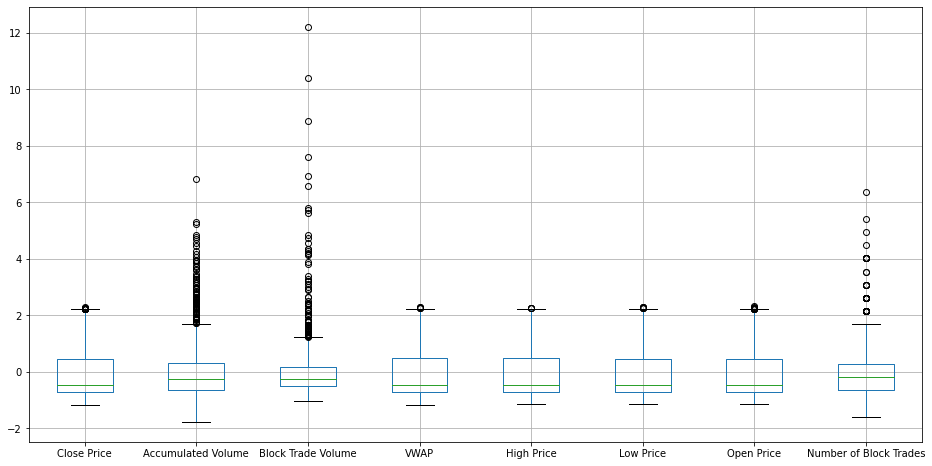

In [101]:
scaled_df.boxplot()

It is important to note that outlier detection through a boxplot can only be used for initial insight as the outliers are detected assuming features are disconnected from each other. Let's now use an isolation forest to detect the outliers within our feature set. Isolation forests will look into all the interconnections within the feature set provided:

In [102]:
outlier_model = IsolationForest(n_estimators=300, contamination=0.1)
outlier_model.fit(scaled_df)
outlier_predictions = outlier_model.predict(scaled_df)
outlier_predictions

IsolationForest(contamination=0.1, n_estimators=300)

In [103]:
outlier_predictions = outlier_model.predict(scaled_df)
outlier_predictions

array([-1, -1,  1, ...,  1,  1, -1])

In [111]:
outliers = scaled_df[outlier_predictions == -1]
outliers

,Close Price,Accumulated Volume,Block Trade Volume,VWAP,High Price,Low Price,Open Price,Number of Block Trades
0,-1.163747,0.307440,0.258475,-1.159720,-1.156918,-1.153624,-1.144636,0.275118
1,-1.140575,-0.713766,-0.774592,-1.139880,-1.143911,-1.133830,-1.136027,-1.127676
6,-1.108291,-0.724054,-0.551194,-1.111704,-1.118368,-1.105558,-1.110492,-1.595274
9,-1.113361,-0.290104,0.802967,-1.114397,-1.119902,-1.107110,-1.107301,1.210315
12,-1.112731,0.161063,0.571758,-1.113171,-1.120252,-1.105061,-1.107562,1.210315
...,...,...,...,...,...,...,...,...
1320,1.942017,-0.123514,0.683867,1.973743,1.988665,1.985572,2.026035,0.275118
1335,1.326279,1.114106,0.254036,1.375670,1.466176,1.349697,1.490531,0.275118
1337,1.322960,1.332616,-0.245666,1.343350,1.384061,1.350360,1.421478,-0.192480
1338,1.185110,2.273621,0.226837,1.196810,1.224511,1.162887,1.164383,1.677913


We can see that the algorithm detected 136 outlier points in our dataset. We will now write a small example to see the effect of removing the outlier data on a simple regressing AI trying to predict number of block trades on this dataset.

In [109]:
y = scaled_df['Number of Block Trades']
x = scaled_df.drop(['Number of Block Trades'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
regressor_model = RandomForestRegressor(n_estimators=50)
regressor_model.fit(x_train, y_train)
y_hat = regressor_model.predict(x_test)

rmse = sqrt(mean_squared_error(y_test, y_hat))
print(f'RMSE without outlier removal: {rmse}')

RMSE without outlier removal: 0.6661564163581338


Let's now train and evaluate the same model after outlier removal:

In [115]:
x_clean = x.drop(outliers.index.values.tolist())
y_clean = y.drop(outliers.index.values.tolist())

In [117]:
x_train, x_test, y_train, y_test = train_test_split(x_clean, y_clean, test_size=0.25)
regressor_model = RandomForestRegressor(n_estimators=50)
regressor_model.fit(x_train, y_train)
y_hat = regressor_model.predict(x_test)

rmse = sqrt(mean_squared_error(y_test, y_hat))
print(f'RMSE with outlier removal: {rmse}')

RMSE with outlier removal: 0.6217787493786675


We can see that the model performance has increased after removing the detecteed outliers from the Isolation Forest, therefore we could benefit if we removed those from the final feature set.

### Conclusions
In this article we have explored several Blueprints regarding imputation, the process of interpolating missing values. We have looked into both baseline techniques as well as somewhat more sophisticated ones. We have also looked at Scaling methodologies to use when the AI is known to be sensitive during the modelling and evaluation phase. Finally, we explored outlier detection and have quantified its potential benefits through a simple Random Forest regression Blueprint.